In [1]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import statistics as stat

from matplotlib.font_manager import FontProperties
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from abc import ABCMeta, abstractmethod

%matplotlib inline
plt.rcParams['axes.unicode_minus']=False
engine = create_engine('sqlite:///fund.db')

# 抓出12月的資料以分群

In [2]:
month_data = pd.read_sql(sql='select * from price where date between "2016-12-01" and "2016-12-31" order by date asc', con=engine,index_col='date')

In [3]:
month_data

,id,NAV
date,,
2016-12-01,0050 元大台灣50,71.9900
2016-12-01,0051 元大中型100,25.8800
2016-12-01,0052 富邦科技,43.4000
2016-12-01,0053 元大電子,29.6900
2016-12-01,0054 元大台商50,21.2400
2016-12-01,0055 元大MSCI金融,14.4800
2016-12-01,0056 元大高股息,23.3400
2016-12-01,0057 富邦摩台,42.3300
2016-12-01,0058 富邦發達,40.4000


# 從所有基金裡隨機選出300檔做為基金池

In [106]:
random_names = pd.read_sql(sql='select distinct id from price where date between "2017-12-01" and "2017-12-31" order by date asc',
                                 con=engine)

In [107]:
random_names.id.values

array(['0050 元大台灣50', '0051 元大中型100', '0052 富邦科技', ...,
       'T0125B 兆豐3Y新興亞債B$', 'T0125C 兆豐3Y新興亞債AC', 'T0125D 兆豐3Y新興亞債BC'],
      dtype=object)

In [108]:
a = pd.read_sql(sql='select * from price where date between "2017-12-01" and "2017-12-31" order by date asc',
                                 con=engine)

In [117]:
temp = []
for i in random_names.id.values:
    temp += list(a[a.id == i].index[1:-1])

In [121]:
a = a.drop(index=temp,axis=1)

In [122]:
a

,id,date,NAV
0,0050 元大台灣50,2017-12-01,82.6000
1,0051 元大中型100,2017-12-01,31.4600
2,0052 富邦科技,2017-12-01,53.4700
3,0053 元大電子,2017-12-01,36.1300
4,0054 元大台商50,2017-12-01,23.9400
5,0055 元大MSCI金融,2017-12-01,16.2600
6,0056 元大高股息,2017-12-01,24.8700
7,0057 富邦摩台,2017-12-01,49.7600
8,0058 富邦發達,2017-12-01,46.2100
9,0059 富邦金融,2017-12-01,40.2100


In [126]:
for i in random_names.id.values:
    b = a[a.id == i].NAV.values
    print((b[1] - b[0])/b[0]*100)

-0.3631961259079869
0.7310870947234597
-0.9538058724518385
-1.7990589537780395
0.835421888053464
0.6765067650676472
1.1258544431041317
-0.3416398713826258
0.47608742696385814
0.5968664511315643
0.7853403141361182
-0.7427413909520676
-0.2874314084139183
0.1888574126534359
0.6806930693069271
0.9885696632684593
1.3945857260049215
-0.3427592116538059
0.0
-0.05702879954377852
-0.527505651846272
2.303771661569832
-2.097902097902103
1.8583626318432998
2.1613832853025903
3.0259365994236305
2.479784366576824
-2.34806629834254
1.6435986159169507
2.590673575129528
-1.503759398496245
3.254769921436578
-0.6253908692933061
-1.4245014245014196
0.7430069930070005
0.29473684210526435
1.7782088587132256
-1.4044943820224793
1.7585551330798528
4.718640093786634
-2.94784580498866
3.093239063190452
7.328691828508611
-4.089456869009588
2.871480345692783
-2.2471910112359472
-0.47204066811909584
0.32679738562092747
-0.7385914006858192
-0.2323780015491817
-0.4817342432757969
-0.1048584411045129
-0.1523229246001

2.83005790208895
2.3702987060103897
2.976149192771553
2.635928153759676
2.4225063938618923
1.9714790663660113
3.1430278455224827
1.9073569482288906
1.3539651837524234
1.9730941704035772
1.7730496453900804
0.05030181086519901
0.02908793840783582
0.7612129754577932
0.029404598879255877
-0.029456291658381418
2.5531914893617107
0.67502410800386
0.09353364318361991
-0.24260531819538544
1.828322105993395
-0.33628417125993987
1.8115942028985552
2.533172496984329
1.8612521150592118
0.0
-0.3530450132391962
0.6006006006006012
0.25728987993138386
-1.4705882352941124
-0.44742729306488066
0.2036659877800364
-0.2657154673283757
-0.26553372278280346
0.339035290491614
0.33618139313568135
0.48590864917396226
0.29154518950438424
1.1549566891241503
1.0587102983638057
1.6477857878475628
1.5463917525773232
2.2426095820591114
2.2448979591836618
1.9152404237978908
1.2809917355371994
-0.0740740740740725
-1.391035548686242
-1.0670731707316983
-4.689480354879596
-2.494154325798911
-2.3326572008113455
0.38477982

0.17211703958693073
1.636520241171415
0.38684719535784257
-0.28708133971291255
1.000909918107365
-0.19960079840318934
-0.5030181086519008
0.39215686274510714
0.09881422924902732
-1.2219959266802545
-3.14500417478431
-1.4770057066129498
-0.3731343283582104
-5.653206650831359
-2.710200597524533
1.9245875883739136
0.37273695420660424
0.307455803228293
0.9243697478991548
0.9821428571428681
-0.05628212153976074
1.125967628430671
0.9329940627650654
0.832342449464926
0.30234315948601015
0.1071811361200406
-0.3703703703703789
-0.7099391480730253
2.3308270676691634
2.275077559462261
0.0
0.0
-0.6304824561403424
-3.103605659516201
1.2313104661389673
1.3323983169705436
0.6451612903225784
-0.6874427131072346
0.016634783331950544
-1.1971268954509067
1.704545454545452
0.03144751040541866
3.732241752949668
-5.914972273567472
0.018246661690306063
1.56754264638082
-0.6674757281553363
1.081081081081082
0.8831521739130367
2.0583190394511166
0.2542853331554723
-0.17789345495354503
4.424103737604883
0.21647

0.27937420178799033
0.3000670200450904
1.4245738997710418
1.2867482798677488
1.2776400344077394
0.26774847870182417
0.32171581769436947
0.29228368181798525
-1.3330233279082375
-1.3371218452281417
0.24142926122646063
-0.06071807718450241
-0.09551098376313072
-0.1081293620367634
-0.03937395412934959
1.2006997455470665
1.2638230647709314
0.44832172756435484
0.3763955342902733
0.4373474369406091
-0.7798566853533958
-0.7321729575773755
4.057731218914149
0.6084342115673571
0.09186095891842688
-0.44779075984540145
4.407672898122433
0.696180146191947
-0.5077893676646911
2.764336325468385
1.9410543714833899
0.43766822383173953
2.714858021114157
1.8918332247992042
0.38947431702435703
3.113516168357905
0.7448052192932706
4.462950583185281
3.1337758488639165
3.1834653632226475
0.2008666115054613
0.26465788206028995
1.379705177591074
1.4286449676435182
0.8916938681161652
0.940658373247327
4.772539707819943
4.823046709366887
2.9406245112860336
2.9899484093372575
3.3907999646831803
-0.290900374792991

1.8810321055741546
0.18838304552589866
0.2235469448584155
0.18951358180669212
0.22488755622188428
-0.19035532994923454
-0.150602409638551
0.14119308153901414
0.12562814070352235
0.12674271229405165
-0.19035532994923454
-0.150602409638551
-0.19035532994923454
-0.150602409638551
0.19485580670304253
-0.11112875059532593
-0.08420774546144458
-0.08676825438799786
0.13551447100959368
-0.11066864672109754
-0.08417030774178227
-0.08646736105590602
-0.11147359916547658
0.9098249961713626
0.6427671314092349
0.8685063926543468
2.6795576682015083
1.2473780115317084
1.3890290249890733
2.1649848518044577
1.1454203842332555
0.9131189749116811
0.004808448881821393
0.14423870636996702
0.003199181009668278
0.1440162602509613
1.2574259846305482
2.908294764492252
0.5353533396619965
2.07611366643563
2.650491753090195
1.1165240675680317
1.9730673056886854
2.469679309396463
0.4346518273424597
0.4346351838722513
1.2971188784587633
0.15403078725796202
0.15092600593334676
0.0405007016981931
0.03988518763843638


-1.3400335008375281
-0.5499541704857974
1.0256410256410342
1.6183986371379855
1.8518518518518452
0.22421524663676654
-0.3542510121457504
1.0796723752792223
4.497751124437774
4.411335086181727
0.08554319931565259
0.0
0.0
4.595404595404592
3.361344537815118
4.5473508552357105
3.252647503782146
1.3054830287206296
1.7160686427457008
0.18018018018017634
1.8618821936357506
-0.15948963317384032
1.64569215876089
0.44469149527516316
-0.33240997229918157
0.0
1.2877442273534598
2.047058823529406
0.8441558441558377
-5.527383367139959
2.3680649526387105
2.3037542662116004
2.323717948717942
0.0
-0.09057971014492561
-0.5185545292497169
2.954545454545452
3.56944570626773
1.6042780748663141
1.499063085571508
-0.693568726355608
0.2684891383939454
0.2033553634977079
1.271186440677964
0.0
4.918032786885247
4.938271604938276
-0.5859375000000049
-0.6103763987792522
-0.5793742757821635
-1.8701870187018694
-2.047781569965867
-0.35460992907800665
-0.6458279514337381
-1.1126564673157173
1.2520868113522567
4.822

1.3505108083467454
-0.41876520853376104
3.4314644665291585
1.5089676863743484
1.6228590808885766
-0.1524147097917614
1.1968503937007955
2.0518713066316483
0.8162072221972377
0.6569617085175559
2.8021015761821393
-0.44868896925857976
-0.30897387353274725
-0.2928353437000416
2.735470390938579
2.8755099517863756
2.9004521706534208
0.8584471196574291
0.8120515837312804
0.8846197653669619
0.49987114216664696
0.6352484824059912
0.5236469098119021
-0.31290743155149886
-0.49465665008993875
-0.4918032786885265
-0.0402069025471621
-0.015033148091539572
-0.04164497657469239
3.7584477872247684
3.898453296985512
3.783747705656603
1.8946850393700687
0.4228450615696746
0.36673846727518244
0.4333397328652489
0.42747788050501295
-3.087788165815277
-0.35594097851411555
-0.3580192284484552
-0.08826702409362248
-0.08802429470534617
0.36713945023221284
0.3120996090541702
0.37303490540900763
-0.5419337783358622
-0.49790615623041873
-0.5417284202994704
-0.49659201557936233
0.7513323800858036
0.61536586851885

-0.07961783439490276
0.7575757575757607
2.217294900221735
-0.2680965147453026
-0.29013539651836906
2.968036529680356
1.451278507256386
1.5721067787376308
1.2372634643376996
1.3743815283122593
1.1457670273710994
1.2099213551119135
0.34482758620689596
0.0
0.19212295869355978
0.2866972477064057
-0.20387359836902497
0.20060180541624445
0.4302189517561075
0.6859413537955488
0.6656438605499059
2.6929604599247847
0.631023237448996
0.6516758968884101
0.9215120692272757
0.9210066410345987
0.9630832120717612
0.9602219663242277
0.46838407494146683
0.02572300003675247
0.667591246852673
1.7127193951987245
2.228211174743732
1.5008148031330417
1.5804968751614052
1.5688587437334094
0.6571195504395885
1.483413481131306
1.6924208977189152
0.008000640051203215
2.214231642694936
3.506493506493514
5.661298194241084
-0.14167393199650916
6.333050607859761
1.8473630086675488
1.8514628657164318
-0.880572372041832
-0.2872902780969831
-0.28013582342952964
-0.6606431555426152
-0.6041262965918125
-0.51103843008994

0.4926108374384277
0.7223552139767329
0.5091649694501018
0.24870862827624918
2.2471910112359645
2.149106124001526
0.8219178082191864
1.1242167342425349
0.7256062631277498
1.8209408194233705
2.1969211032713236
0.17924067133778626
-0.020060180541620884
-0.09674922600618645
-0.08494372478234498
1.8061881576880656
1.7122650288479466
-0.0369617445943375
-0.021422450728359063
0.1803254818946511
-0.021626297577865734
1.4676450967311583
0.0627628193058456
-0.18476698829809773
0.7255379416588051
0.5081102208325151
0.8089976322020594
-0.6324110671936765
0.34079844206426624
0.29481132075472116
1.679990731085625
0.7096314227446774
0.10020040080160107
0.39708802117803105
2.2212543554006947
-2.4165707710011466
0.6330295970825535
0.7371007371007318
0.0
0.03489183531054279
0.3139101432215101
-0.7029053420805931
1.6073636488528469
0.2886836027713667
0.10020040080160107
-0.10373443983402268
-0.2864066975104705
0.827250608272497
0.7499278915488837
1.25988866100205
1.255580357142845
1.8654230512991414
0.8

1.36642218426605
0.6341880031255128
2.339146830073061
0.8605174353205856
0.3557855583407437
2.2927357469045737
2.5217765351113015
0.910707933119887
0.03434196970276332
-0.47752517388144267
-0.4889019262735895
2.4322984445683726
-0.2128694805984639
-0.16082341588935578
-0.6066622545775393
2.942574885096953
2.857383681726231
0.15716767309123808
0.0
0.9390755880521521
-0.3680645684620264
0.46822047898199687
1.750477932008972
1.0114632501685747
0.9665627306037018
0.9431271093088273
0.4840271055179154
0.5114763224736463
0.48785699024286183
0.5585018311940548
-0.06361323155216761
-0.11273957158963223
-0.13543054400388443
0.531662692270147
0.4848710029491594
0.4616801044031716
0.39410014941536786
0.34737378146369663
0.3244073748902471
-0.6713551847086093
-0.7177108471495258
-0.7405338299192991
0.4510544296319203
0.3177023764137688
1.7602064325868694
0.7162513822030441
1.6845682322809679
0.6398991252891787
1.7144807056377838
0.6697704386502831
1.6907674678617393
0.6462069217099405
-0.670879829

In [120]:
len(random_names)

5409

In [8]:
random_names = month_data['id'].sample(n=300).values

In [9]:
random_names

array(['PYZAK 施羅德美大CaEUh', 'NBZ39 NB美國房產C2mz', 'T0837B 保德多元收益組B',
       'MGF17 宏利巨龍增長A', 'FTZJ5 富達通膨AHe.acc', 'SBZ79 瑞銀大中華',
       'PIM57 PIMCO全球債H.I', 'T4713Y 台新大眾貨幣市場', 'NBZ99 NB新本地貨債Bza',
       'T2055B 日盛中國戰略A股C', 'T2113A 柏瑞新興高收債 A', 'T3259E 野村環高債AC',
       'T1658F 群益全球地產BC', 'MFZH0 MFS全球股I1.EUR', 'T2108B 柏瑞美國雙核收 B',
       'T0458E 匯豐中國多息平A$', 'T4508F 富蘭積極回報債BC', 'T2121A 柏瑞中國平衡A',
       'T0598C 元大新興印尼債B$', 'PIZK5 鋒裕策收益U2', 'T0431Y 匯豐全球關鍵資源',
       'FTZP4 富達歐洲入息 Ame', 'AIZ43 柏瑞拉美A', 'ISZ54 景順泛歐洲Ce',
       'ISZK4 景順新興企業債C$', 'ALZ96 聯博歐元區股AXe', 'DWS20 DWS新資源LD',
       'T3731Y 國泰中國內需增長', 'GSF43 天達新貨幣債Facc', 'SBZ47 瑞銀策略固收歐元',
       'ALZHG 聯博中國時ADaumH', 'T1026Y 富邦全球不動產', 'NBZ12 NB美國房產T$a',
       'T3739Y 國泰紐幣八年保本', 'T1233C 華南人民幣高收AC', 'T4717C 台新北美收益 A$',
       '00653L 富邦印度正2', 'ISZ43 景順能源B$', 'PIZA8 鋒裕新興債B2',
       '00655L 國泰中國A50正2', 'PTZ12 百達保安R$', 'T3604Y 安聯台灣科技',
       'ISZL1 景順泛歐洲C$H', 'EDM23 愛德蒙美價收Ausd', 'FPZ07 法盛美股R/A.$',
       'FLZ53 富蘭坦美短票$Bmd', 'FLZ25 富蘭坦伯亞洲成長', 'T3

# 拿出12月所有有淨值的日子

In [10]:
month_date = pd.read_sql(sql='select distinct date from price where date between "2016-12-01" and "2016-12-31" order by date asc', con=engine,index_col='date').index

In [11]:
month_date

Index(['2016-12-01', '2016-12-02', '2016-12-05', '2016-12-06', '2016-12-07',
       '2016-12-08', '2016-12-09', '2016-12-12', '2016-12-13', '2016-12-14',
       '2016-12-15', '2016-12-16', '2016-12-19', '2016-12-20', '2016-12-21',
       '2016-12-22', '2016-12-23', '2016-12-26', '2016-12-27', '2016-12-28',
       '2016-12-29', '2016-12-30'],
      dtype='object', name='date')

In [12]:
month_date_len = len(month_date)

# 拿出基金池裡的所有基金的12月淨值

In [13]:
month_NAV = np.zeros((len(random_names),month_date_len))

In [14]:
month_NAV

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
for j in range (len(random_names)):
    temp = month_data[month_data['id'] == random_names[j]]
    month_NAV[j][0] = temp.iloc[0]['NAV']
    for i,day in enumerate(month_date[1:]):
        try:
            month_NAV[j][i+1] = temp.loc[day]['NAV']
        except:
            month_NAV[j][i+1] = month_NAV[j][i]

In [16]:
for i in month_NAV[:5]:
    print (i)

[165.6549 165.6549 165.8184 166.8718 167.5747 169.766  170.1683 170.9728
 170.7136 171.9533 170.5865 171.2795 170.4693 170.6648 171.526  171.2591
 171.2591 171.2591 171.2591 171.2591 171.2591 171.2591]
[87.49 87.49 88.18 88.57 90.33 90.74 90.6  91.35 91.5  89.61 89.09 90.27
 90.98 91.23 90.04 89.93 89.93 89.93 89.93 89.93 89.93 89.93]
[9.5033 9.5196 9.5651 9.5762 9.6089 9.5987 9.6478 9.6221 9.6382 9.6109
 9.6322 9.6353 9.6165 9.6445 9.649  9.6432 9.6948 9.6948 9.6948 9.7334
 9.7493 9.7309]
[1.8825 1.8825 1.867  1.8702 1.8689 1.8779 1.8713 1.8446 1.8533 1.8447
 1.8104 1.8063 1.7911 1.7835 1.7911 1.7734 1.7734 1.7734 1.7734 1.7734
 1.7734 1.7734]
[11.8  11.8  11.8  11.8  11.82 11.8  11.79 11.8  11.8  11.83 11.74 11.73
 11.75 11.76 11.78 11.78 11.81 11.81 11.81 11.81 11.81 11.81]


# 計算基金池裡的所有基金的12月漲跌幅

In [17]:
month_rate = np.zeros((len(random_names),month_date_len-1))

In [18]:
month_rate

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
for j in range (len(random_names)):
    for i in range (month_date_len-1):
        month_rate[j][i] = (month_NAV[j][i+1] - month_NAV[j][i]) / month_NAV[j][i]

In [20]:
for i in month_rate[:5]:
    print (i)

[ 0.          0.00098699  0.00635273  0.00421222  0.01307656  0.00236973
  0.00472767 -0.00151603  0.00726187 -0.00794867  0.00406246 -0.00473028
  0.00114683  0.00504615 -0.00155603  0.          0.          0.
  0.          0.          0.        ]
[ 0.          0.00788662  0.00442277  0.01987129  0.00453891 -0.00154287
  0.00827815  0.00164204 -0.02065574 -0.00580292  0.01324503  0.00786529
  0.00274786 -0.01304395 -0.00122168  0.          0.          0.
  0.          0.          0.        ]
[ 0.00171519  0.00477961  0.00116047  0.00341472 -0.00106152  0.00511528
 -0.00266382  0.00167323 -0.00283248  0.00221623  0.00032184 -0.00195116
  0.00291166  0.00046659 -0.0006011   0.00535092  0.          0.
  0.00398152  0.00163355 -0.00188731]
[ 0.         -0.00823373  0.00171398 -0.00069511  0.00481567 -0.00351456
 -0.01426816  0.00471647 -0.00464037 -0.01859381 -0.00226469 -0.00841499
 -0.0042432   0.00426128 -0.0098822   0.          0.          0.
  0.          0.          0.        ]
[ 0.

# 使用K-Means進行分群，並用MDS壓成2維座標，圖形化呈現

In [21]:
kmeans = KMeans(n_clusters=4, n_jobs=8).fit(month_rate)

In [22]:
mds = MDS(n_components=2, dissimilarity='euclidean', n_jobs=8).fit(month_rate).embedding_

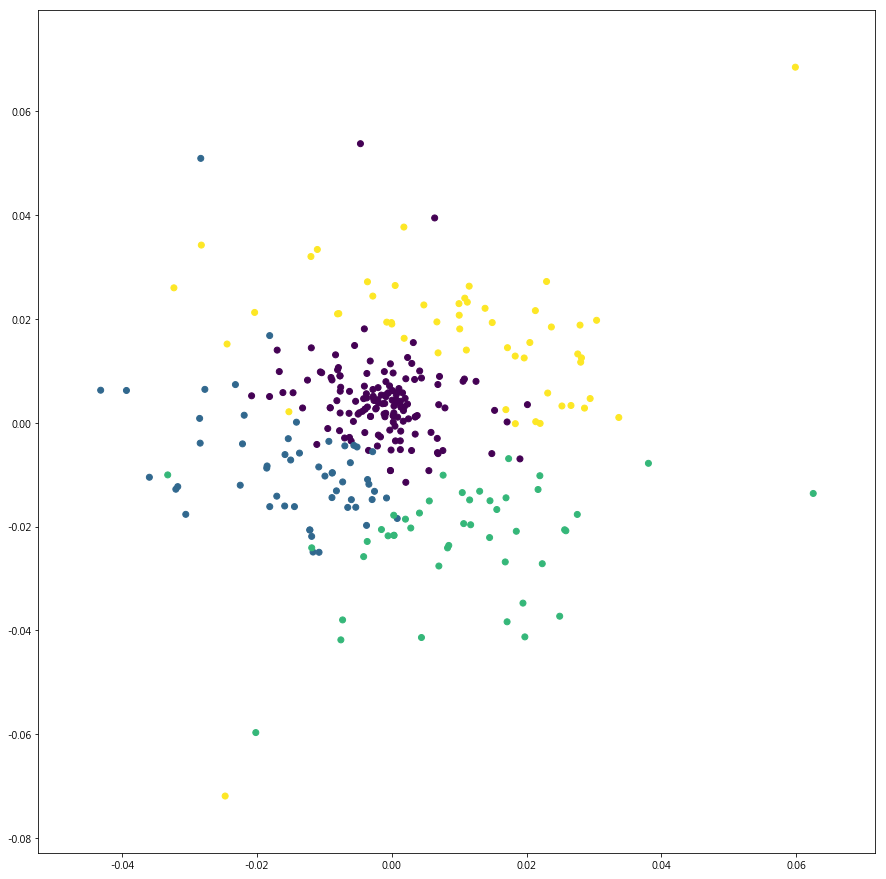

In [23]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(bottom=0.1)
plt.scatter(mds[:, 0], mds[:, 1], c=kmeans.labels_)

#for label, x, y in zip(random_names, mds[:, 0], mds[:, 1]):
#    plt.annotate(
#        label,
#        xy=(x, y), xytext=(-3, 3),
#        textcoords='offset points', ha='right', va='bottom')
plt.show()

# 使用hierarchical進行分群，並用MDS壓成2維座標，圖形化呈現

In [24]:
hierarchical = AgglomerativeClustering(n_clusters=4).fit(month_rate)

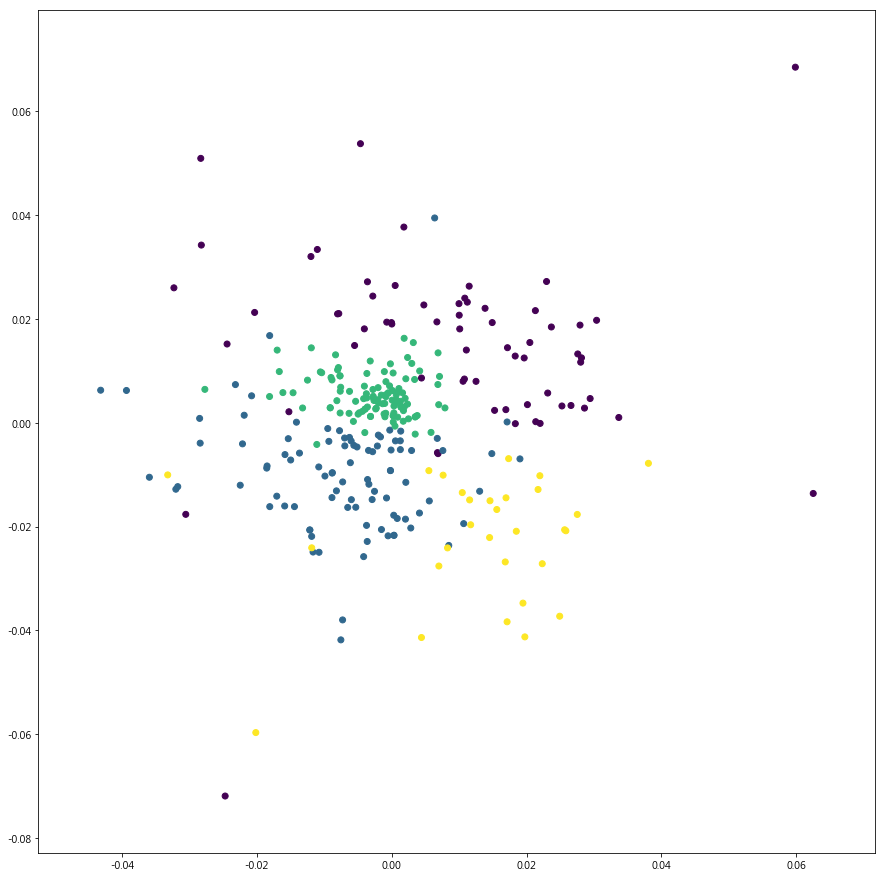

In [25]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(bottom=0.1)
plt.scatter(mds[:, 0], mds[:, 1], c=hierarchical.labels_)

#for label, x, y in zip(random_names, mds[:, 0], mds[:, 1]):
#    plt.annotate(
#        label,
#        xy=(x, y), xytext=(-3, 3),
#        textcoords='offset points', ha='right', va='bottom')
plt.show()

# 開始進行收益率回測，對比對象為台灣50，時間範圍為2017年

In [26]:
data = pd.read_sql(sql='select * from price where date between "2017-01-01" and "2017-12-31" order by date asc', con=engine,index_col='date')

In [27]:
data

,id,NAV
date,,
2017-01-03,0050 元大台灣50,72.0300
2017-01-03,0051 元大中型100,25.6800
2017-01-03,0052 富邦科技,43.4000
2017-01-03,0053 元大電子,29.8400
2017-01-03,0054 元大台商50,21.3400
2017-01-03,0055 元大MSCI金融,14.5000
2017-01-03,0056 元大高股息,23.1800
2017-01-03,0057 富邦摩台,42.2800
2017-01-03,0058 富邦發達,40.2900


# 從四個分群裡隨機選出4檔基金(K-Means)

In [28]:
camp = pd.DataFrame(data=kmeans.labels_, index=random_names,columns=['label'])

In [29]:
camp

,label
PYZAK 施羅德美大CaEUh,0
NBZ39 NB美國房產C2mz,1
T0837B 保德多元收益組B,0
MGF17 宏利巨龍增長A,3
FTZJ5 富達通膨AHe.acc,0
SBZ79 瑞銀大中華,3
PIM57 PIMCO全球債H.I,0
T4713Y 台新大眾貨幣市場,0
NBZ99 NB新本地貨債Bza,0
T2055B 日盛中國戰略A股C,3


In [30]:
choose_name = []
for i in range(4):
    choose_name.append(camp[camp['label'] == i].sample(n=1).index[0])

In [31]:
choose_name.append('0050 元大台灣50')

In [32]:
choose_name

['CPA72 瀚亞全價值Andmc1',
 'AIZ43 柏瑞拉美A',
 'PYZBP 施羅德精選CaEU',
 'ANZ07 安本亞太股票A$',
 '0050 元大台灣50']

# 找出2017年所有有淨值的日子

In [33]:
year_date = pd.read_sql(sql='select distinct date from price where date between "2017-01-01" and "2017-12-31" order by date asc', con=engine,index_col='date').index

In [34]:
year_date

Index(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-09',
       '2017-01-10', '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-16',
       ...
       '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21', '2017-12-22',
       '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29'],
      dtype='object', name='date', length=246)

In [35]:
year_date_len = len(year_date)

# 拿出四檔基金與台灣50，於2017年的所有淨值

In [36]:
year_NAV = np.zeros((5,year_date_len))

In [37]:
year_NAV

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
for j in range (5):
    temp = data[data['id'] == choose_name[j]]
    year_NAV[j][0] = temp.iloc[0]['NAV']
    for i,day in enumerate(year_date[1:]):
        try:
            year_NAV[j][i+1] = temp.loc[day]['NAV']
        except:
            year_NAV[j][i+1] = year_NAV[j][i]

In [39]:
for i in year_NAV:
    print (i)

[10.097 10.187 10.237 10.186 10.166 10.183 10.2   10.219 10.239 10.204
 10.176 10.168 10.164 10.199 10.183 10.21  10.219 10.272 10.304 10.283
 10.207 10.269 10.337 10.386 10.379 10.446 10.497 10.424 10.424 10.45
 10.491 10.472 10.503 10.503 10.503 10.529 10.479 10.439 10.398 10.403
 10.358 10.424 10.42  10.347 10.409 10.498 10.478 10.459 10.384 10.273
 10.322 10.322 10.322 10.322 10.322 10.322 10.322 10.352 10.258 10.242
 10.295 10.241 10.244 10.195 10.195 10.195 10.172 10.193 10.174 10.199
 10.347 10.445 10.466 10.446 10.446 10.361 10.34  10.322 10.368 10.432
 10.43  10.423 10.365 10.357 10.419 10.44  10.337 10.214 10.333 10.404
 10.392 10.392 10.392 10.392 10.392 10.392 10.461 10.461 10.461 10.427
 10.467 10.431 10.466 10.498 10.526 10.529 10.421 10.434 10.508 10.45
 10.405 10.394 10.394 10.454 10.454 10.454 10.454 10.454 10.498 10.498
 10.486 10.458 10.423 10.44  10.435 10.52  10.525 10.593 10.628 10.609
 10.631 10.695 10.616 10.615 10.615 10.615 10.615 10.615 10.615 10.615
 10.694 

# 計算四檔基金與台灣50，於2017年的漲跌幅

In [40]:
year_rate = np.zeros((5,year_date_len-1))

In [41]:
year_rate

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
for j in range (5):
    for i in range (year_date_len-1):
        year_rate[j][i] = (year_NAV[j][i+1] - year_NAV[j][i]) / year_NAV[j][i]

In [43]:
for i in year_rate:
    print (i)

[ 8.91353867e-03  4.90821635e-03 -4.98192830e-03 -1.96347929e-03
  1.67224080e-03  1.66944908e-03  1.86274510e-03  1.95713866e-03
 -3.41830257e-03 -2.74402195e-03 -7.86163522e-04 -3.93391031e-04
  3.44352617e-03 -1.56878125e-03  2.65147795e-03  8.81488737e-04
  5.18641746e-03  3.11526480e-03 -2.03804348e-03 -7.39083925e-03
  6.07426276e-03  6.62187165e-03  4.74025346e-03 -6.73984210e-04
  6.45534252e-03  4.88225158e-03 -6.95436791e-03  0.00000000e+00
  2.49424405e-03  3.92344498e-03 -1.81107616e-03  2.96027502e-03
  0.00000000e+00  0.00000000e+00  2.47548320e-03 -4.74878906e-03
 -3.81715813e-03 -3.92757927e-03  4.80861704e-04 -4.32567529e-03
  6.37188646e-03 -3.83729854e-04 -7.00575816e-03  5.99207500e-03
  8.55029302e-03 -1.90512479e-03 -1.81332315e-03 -7.17085763e-03
 -1.06895223e-02  4.76978487e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.90641349e-03 -9.08037094e-03 -1.55975824e-03  5.17477055e-03
 -5.24526469e-03  2.92940

# 計算四檔基金的合計漲跌幅，並圖像化

In [44]:
choose_rate = []
for i in range(year_date_len-1):
    temp = (year_rate[0][i] + year_rate[1][i] + year_rate[2][i] + year_rate[3][i])/4
    choose_rate.append(temp)

In [45]:
choose_rate

[0.0050677602953479815,
 0.00711065672147616,
 -0.004482630231668005,
 -0.0005877786430100782,
 0.0038872833986345837,
 0.005125136055969684,
 0.00432600857697845,
 -0.001874859340990492,
 -0.0021552106972163717,
 0.0017985929256482556,
 -0.0005258502917034905,
 0.001728686324051871,
 0.0018677609092511334,
 0.007763927869158482,
 0.0035287005249838342,
 0.006098832761190209,
 0.0030537970024412018,
 0.0019824814205215415,
 -0.0019334995883341778,
 0.0009741128492938252,
 0.0029745107831724814,
 0.009516310497404963,
 0.00570500276836538,
 0.0011210812881223993,
 0.00895514031276764,
 -8.704911613590706e-05,
 -0.005118414244206983,
 0.0,
 0.002657864663978191,
 0.006629367455863065,
 0.0018635561335270316,
 -0.0006118578202141166,
 0.0,
 0.0,
 -0.008084245166188534,
 -0.0023328258422372168,
 -0.0016310667346882408,
 -0.0019007587759792741,
 -0.005010796752463342,
 -0.007222967271143427,
 0.0052527083048316695,
 0.004440539149754608,
 -0.005148216923683038,
 0.0106075707465468,
 0.00880

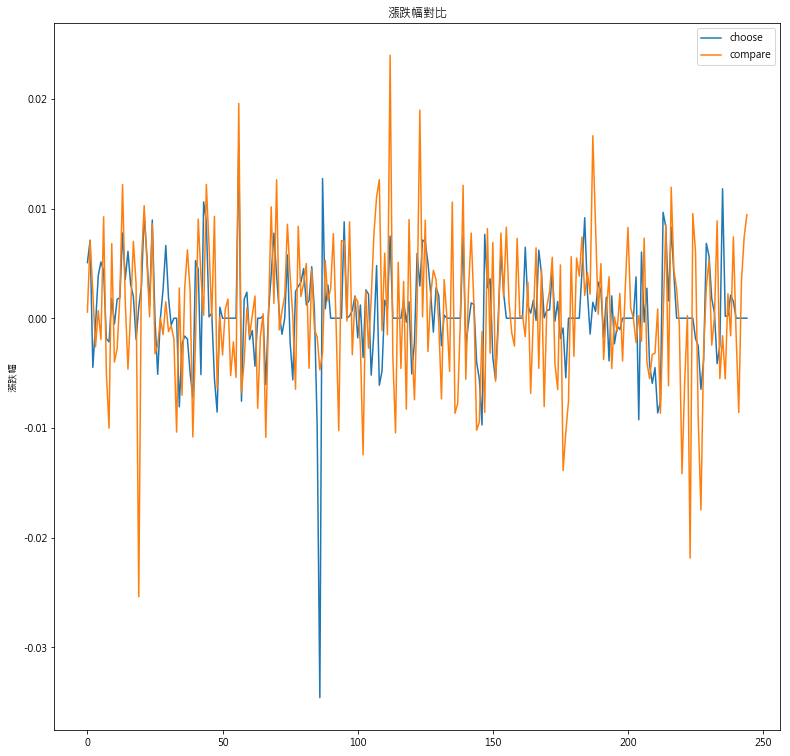

In [46]:
plt.figure(figsize=(13, 13))
plt.ylabel('漲跌幅')
plt.title('漲跌幅對比')
plt.plot(choose_rate)
plt.plot(year_rate[-1])
plt.legend(['choose','compare'])
plt.show()

# 計算四檔基金與台灣50，自2017年初至年尾的收益率，並圖像化

In [47]:
choose_profit = []
compare__profit = []
start = (year_NAV[0][0] + year_NAV[1][0] + year_NAV[2][0] + year_NAV[3][0])/4
for i in range(year_date_len):
    temp = (year_NAV[0][i] + year_NAV[1][i] + year_NAV[2][i] + year_NAV[3][i])/4
    temp = (temp-start)/start*100
    choose_profit.append(temp)
    compare__profit.append((year_NAV[4][i]-year_NAV[4][0])/year_NAV[4][0]*100)

In [48]:
choose_profit

[0.0,
 0.3772461434840698,
 0.7500558224563607,
 0.5109633837684767,
 0.3624334851142113,
 0.37999601818144363,
 1.0703612272067549,
 0.8165661251369006,
 0.7168006711161012,
 0.7683516554429176,
 0.5475917147375465,
 0.51862636792518,
 0.8650005848067018,
 0.4500994904665494,
 0.587446565351499,
 0.7567655167179628,
 1.3783105283169343,
 1.7060222622522576,
 2.3190609947873337,
 2.3347902780563583,
 2.4034638154988124,
 2.540040925468502,
 3.4753283075401304,
 4.042022485175449,
 4.295377607293688,
 5.06647913743398,
 4.9248422580211155,
 4.5454695447710876,
 4.5454695447710876,
 4.864051694711121,
 5.481820211725685,
 5.980500821845901,
 6.053390833824357,
 6.053390833824357,
 6.053390833824357,
 5.886748427163335,
 4.950141105236984,
 4.8182204497548495,
 4.801977856542339,
 4.524900482034708,
 3.865297204624057,
 4.0924735196233,
 4.303663896381786,
 4.2093981917557555,
 4.832886448140864,
 5.614730822098877,
 5.5854354903228245,
 5.461287813985281,
 5.29215218759866,
 3.9197447236

In [49]:
compare__profit

[0.0,
 0.05553241704844099,
 0.7635707344162115,
 0.9995835068721349,
 0.7358045258919911,
 0.8052200472025521,
 0.6108565875329692,
 1.541024573094543,
 1.0412328196584755,
 0.027766208524220494,
 0.7080383173677705,
 0.3054282937664846,
 0.027766208524220494,
 0.2221296681938034,
 1.4438428432597417,
 1.5965569901430037,
 1.1245314452311568,
 1.193946966541718,
 1.9019852839094884,
 2.2212966819380733,
 -0.37484381507704573,
 0.1527141468832423,
 1.1800638622795978,
 1.7076218242399057,
 1.7215049285020059,
 2.596140497015139,
 2.262945994724414,
 2.0130501180063898,
 2.0130501180063898,
 1.860335971123148,
 2.0130501180063898,
 1.8881021796473683,
 1.8186866583368073,
 1.6243231986672244,
 0.5692072747466286,
 0.8468693599888928,
 0.1388310426211222,
 0.41649312786338627,
 1.0412328196584755,
 1.2911286963764996,
 0.1943634596695829,
 0.0,
 0.9024017770373535,
 1.2911286963764996,
 1.3188949049007397,
 2.554491184228798,
 3.2347632930723282,
 3.2347632930723282,
 4.192697487158123,


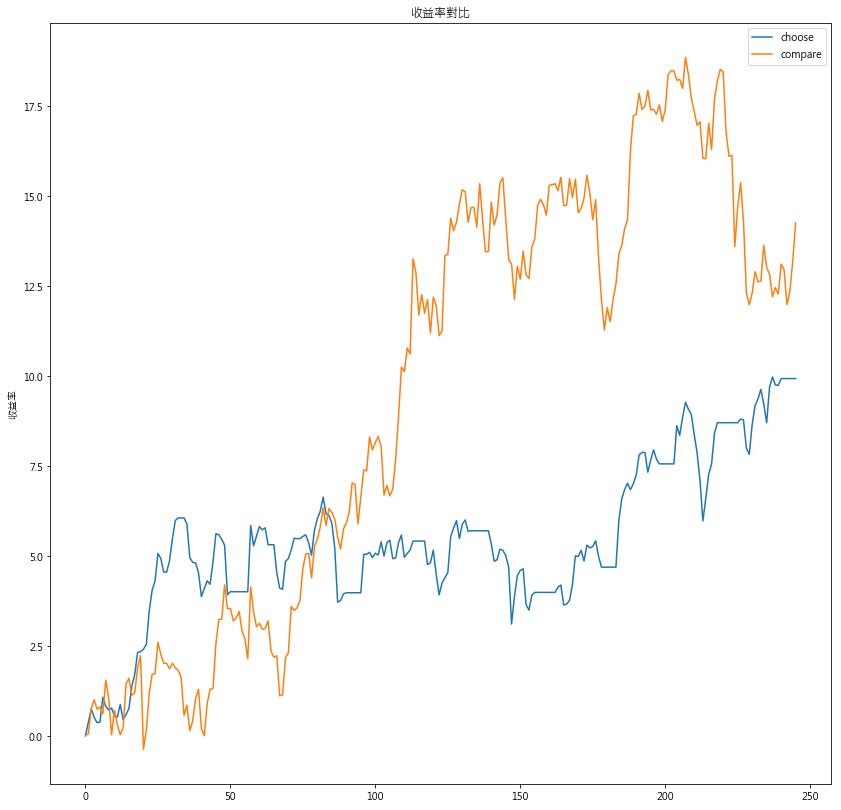

In [50]:
plt.figure(figsize=(14, 14))
plt.ylabel('收益率')
plt.title('收益率對比')
plt.plot(choose_profit)
plt.plot(compare__profit)
plt.legend(['choose','compare'])
plt.show()

In [51]:
camp = pd.DataFrame(data=hierarchical.labels_, index=random_names,columns=['label'])

In [52]:
camp

,label
PYZAK 施羅德美大CaEUh,0
NBZ39 NB美國房產C2mz,1
T0837B 保德多元收益組B,1
MGF17 宏利巨龍增長A,0
FTZJ5 富達通膨AHe.acc,2
SBZ79 瑞銀大中華,0
PIM57 PIMCO全球債H.I,2
T4713Y 台新大眾貨幣市場,2
NBZ99 NB新本地貨債Bza,2
T2055B 日盛中國戰略A股C,0


# 從四個分群裡隨機選出4檔基金(Hierarchical)

In [53]:
choose_name = []
for i in range(4):
    choose_name.append(camp[camp['label'] == i].sample(n=1).index[0])

In [54]:
choose_name.append('0050 元大台灣50')

In [55]:
choose_name

['T4301Y 華頓台灣',
 'T3628A 安聯四季成長組合',
 'T4713Y 台新大眾貨幣市場',
 'ALZFB 聯博國際科技S1e',
 '0050 元大台灣50']

# 找出2017年所有有淨值的日子

In [56]:
year_date = pd.read_sql(sql='select distinct date from price where date between "2017-01-01" and "2017-12-31" order by date asc', con=engine,index_col='date').index

In [57]:
year_date

Index(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-09',
       '2017-01-10', '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-16',
       ...
       '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21', '2017-12-22',
       '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29'],
      dtype='object', name='date', length=246)

In [58]:
year_date_len = len(year_date)

# 拿出四檔基金與台灣50，於2017年的所有淨值

In [59]:
year_NAV = np.zeros((5,year_date_len))

In [60]:
year_NAV

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [61]:
for j in range (5):
    temp = data[data['id'] == choose_name[j]]
    year_NAV[j][0] = temp.iloc[0]['NAV']
    for i,day in enumerate(year_date[1:]):
        try:
            year_NAV[j][i+1] = temp.loc[day]['NAV']
        except:
            year_NAV[j][i+1] = year_NAV[j][i]

In [62]:
for i in year_NAV:
    print (i)

[16.79 16.92 17.04 17.07 16.99 17.   17.06 17.1  17.03 16.85 17.04 17.2
 17.16 17.17 17.39 17.46 17.72 17.73 17.88 17.92 17.85 17.96 18.01 18.23
 18.24 18.34 18.35 18.45 18.52 18.29 18.28 18.65 18.55 18.51 18.48 18.42
 18.41 18.45 18.59 18.66 18.67 18.57 18.86 18.99 18.86 19.03 19.18 19.38
 19.38 19.5  19.64 19.51 19.34 19.18 19.46 19.73 19.76 19.96 19.95 19.95
 19.98 19.55 19.58 19.54 19.21 19.22 19.49 19.3  19.05 19.33 19.17 19.52
 19.61 19.62 19.69 19.82 19.73 19.97 19.8  19.8  19.7  20.1  20.   20.11
 20.36 20.28 20.3  20.33 20.31 20.28 20.24 20.37 20.42 20.25 20.14 20.39
 20.64 20.84 20.9  20.96 20.72 20.81 20.63 20.46 20.28 20.   20.1  20.27
 20.43 20.38 20.61 20.66 20.58 20.84 20.89 20.6  20.47 20.55 20.57 20.42
 20.45 20.55 20.4  20.43 20.54 20.86 20.91 20.9  20.91 21.33 21.36 21.26
 21.22 21.33 21.67 21.71 21.97 21.58 21.71 21.8  21.99 21.89 21.93 22.26
 21.99 21.57 21.04 21.3  20.93 21.38 21.48 21.74 21.75 21.89 21.98 22.22
 22.59 22.68 22.72 22.67 22.82 22.94 23.12 23.04 23.

# 計算四檔基金與台灣50，於2017年的漲跌幅

In [63]:
year_rate = np.zeros((5,year_date_len-1))

In [64]:
year_rate

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [65]:
for j in range (5):
    for i in range (year_date_len-1):
        year_rate[j][i] = (year_NAV[j][i+1] - year_NAV[j][i]) / year_NAV[j][i]

In [66]:
for i in year_rate:
    print (i)

[ 0.0077427   0.0070922   0.00176056 -0.00468658  0.00058858  0.00352941
  0.00234467 -0.00409357 -0.01056958  0.01127596  0.00938967 -0.00232558
  0.00058275  0.01281305  0.0040253   0.01489118  0.00056433  0.00846024
  0.00223714 -0.00390625  0.00616246  0.00278396  0.01221544  0.00054855
  0.00548246  0.00054526  0.00544959  0.00379404 -0.01241901 -0.00054675
  0.0202407  -0.00536193 -0.00215633 -0.00162075 -0.00324675 -0.00054289
  0.00217273  0.00758808  0.00376547  0.00053591 -0.00535619  0.01561659
  0.0068929  -0.00684571  0.00901379  0.00788229  0.01042753  0.
  0.00619195  0.00717949 -0.00661914 -0.00871348 -0.00827301  0.01459854
  0.01387461  0.00152053  0.01012146 -0.000501    0.          0.00150376
 -0.02152152  0.00153453 -0.0020429  -0.01688843  0.00052056  0.01404787
 -0.00974859 -0.01295337  0.01469816 -0.00827729  0.01825769  0.00461066
  0.00050994  0.00356779  0.00660234 -0.00454087  0.01216422 -0.00851277
  0.         -0.00505051  0.02030457 -0.00497512  0.0055   

# 計算四檔基金的合計漲跌幅，並圖像化

In [67]:
choose_rate = []
for i in range(year_date_len-1):
    temp = (year_rate[0][i] + year_rate[1][i] + year_rate[2][i] + year_rate[3][i])/4
    choose_rate.append(temp)

In [68]:
choose_rate

[0.0036307795658531337,
 -0.0005156562663606735,
 0.004773851714684893,
 -0.0010527395298486548,
 0.0003210380626249539,
 0.002606008808960186,
 -0.0028283476153421728,
 -0.001451835122798932,
 -0.002637066228730962,
 -0.0012487553942771555,
 0.004395081917805932,
 -0.0009050107230922672,
 5.4069163593630274e-05,
 0.0022932555167093226,
 0.0050275485015017565,
 0.00426054120431319,
 0.002106136446751961,
 0.002095400839916146,
 0.003209327088313267,
 0.0005778773264923337,
 0.003407747081384061,
 0.0023673645351332817,
 0.005593161955551513,
 -0.0007019209027969944,
 0.002661846291721619,
 -0.0009293294212057554,
 0.0027632224400397374,
 0.0009502854569066261,
 -0.003101199701479301,
 0.00484482637780986,
 0.0056364551757014875,
 -0.0029760378278344927,
 -0.002503876012699189,
 0.0015894052654770862,
 -5.053719713389018e-06,
 -0.0005637196780487366,
 0.0009706663749505599,
 0.0010873478974296955,
 0.0016210739208614602,
 -2.447864950741029e-05,
 -0.0008652460606863048,
 0.0059905744956

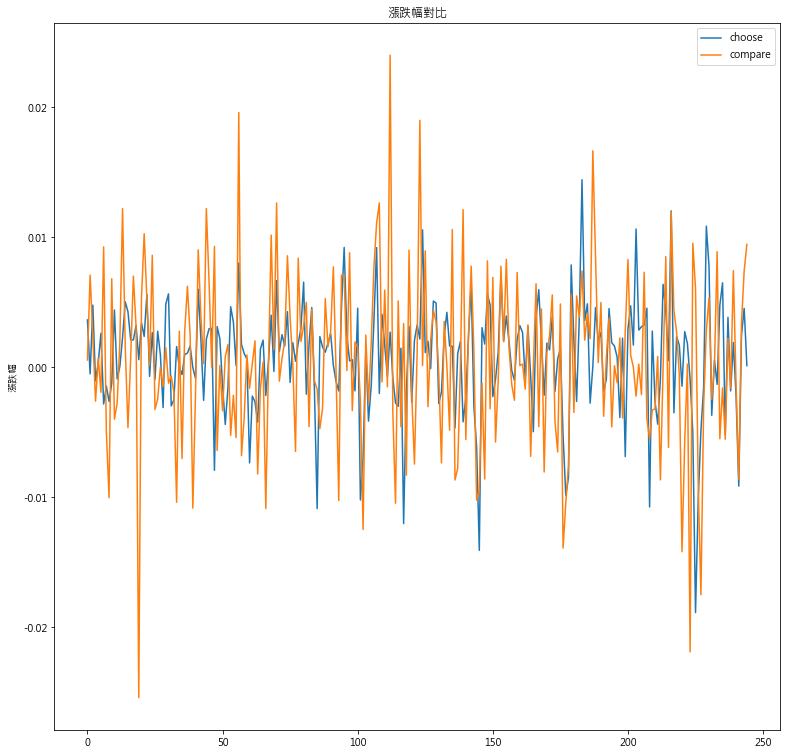

In [69]:
plt.figure(figsize=(13, 13))
plt.ylabel('漲跌幅')
plt.title('漲跌幅對比')
plt.plot(choose_rate)
plt.plot(year_rate[-1])
plt.legend(['choose','compare'])
plt.show()

# 計算四檔基金與台灣50，自2017年初至年尾的收益率，並圖像化

In [70]:
choose_profit = []
compare__profit = []
start = (year_NAV[0][0] + year_NAV[1][0] + year_NAV[2][0] + year_NAV[3][0])/4
for i in range(year_date_len):
    temp = (year_NAV[0][i] + year_NAV[1][i] + year_NAV[2][i] + year_NAV[3][i])/4
    temp = (temp-start)/start*100
    choose_profit.append(temp)
    compare__profit.append((year_NAV[4][i]-year_NAV[4][0])/year_NAV[4][0]*100)

In [71]:
choose_profit

[0.0,
 0.12435288745965632,
 -0.1437809819233818,
 1.0729933787484283,
 0.9882162392703839,
 1.3742269646251637,
 1.792944919716841,
 1.1977387529649217,
 1.2239699512139044,
 1.1064201675395053,
 0.2888702530362082,
 1.1262407487600679,
 0.9366042307455873,
 0.9824597668367049,
 0.9892628706219806,
 2.088291204240964,
 2.8216527094015,
 3.214204880703652,
 3.5807875115947247,
 4.27424619647627,
 4.4247648677254325,
 5.000542940013645,
 5.268807638315616,
 5.988628350365078,
 6.01485954861406,
 6.341997260442454,
 5.871078566690715,
 6.584227003873852,
 6.630082539964969,
 6.479760112094233,
 7.683516995330721,
 7.964864585527454,
 7.3761998647228895,
 7.297767927813845,
 7.3309330587670365,
 7.618822094911142,
 7.043305680460834,
 7.344473851878113,
 7.60619710423271,
 7.939876262008459,
 7.67828383857283,
 7.403673937701896,
 8.254258154239452,
 8.52258826700088,
 8.025503789459654,
 8.10406655528765,
 8.516243064431936,
 8.908991479112515,
 7.01203756883237,
 7.653230100594359,
 7.7

In [72]:
compare__profit

[0.0,
 0.05553241704844099,
 0.7635707344162115,
 0.9995835068721349,
 0.7358045258919911,
 0.8052200472025521,
 0.6108565875329692,
 1.541024573094543,
 1.0412328196584755,
 0.027766208524220494,
 0.7080383173677705,
 0.3054282937664846,
 0.027766208524220494,
 0.2221296681938034,
 1.4438428432597417,
 1.5965569901430037,
 1.1245314452311568,
 1.193946966541718,
 1.9019852839094884,
 2.2212966819380733,
 -0.37484381507704573,
 0.1527141468832423,
 1.1800638622795978,
 1.7076218242399057,
 1.7215049285020059,
 2.596140497015139,
 2.262945994724414,
 2.0130501180063898,
 2.0130501180063898,
 1.860335971123148,
 2.0130501180063898,
 1.8881021796473683,
 1.8186866583368073,
 1.6243231986672244,
 0.5692072747466286,
 0.8468693599888928,
 0.1388310426211222,
 0.41649312786338627,
 1.0412328196584755,
 1.2911286963764996,
 0.1943634596695829,
 0.0,
 0.9024017770373535,
 1.2911286963764996,
 1.3188949049007397,
 2.554491184228798,
 3.2347632930723282,
 3.2347632930723282,
 4.192697487158123,


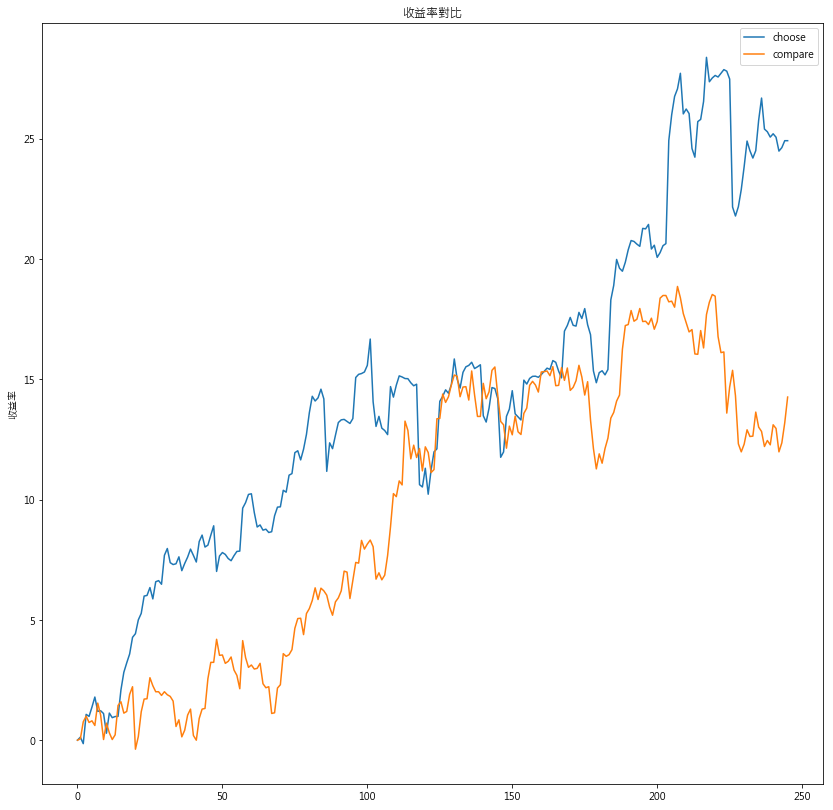

In [73]:
plt.figure(figsize=(14, 14))
plt.ylabel('收益率')
plt.title('收益率對比')
plt.plot(choose_profit)
plt.plot(compare__profit)
plt.legend(['choose','compare'])
plt.show()